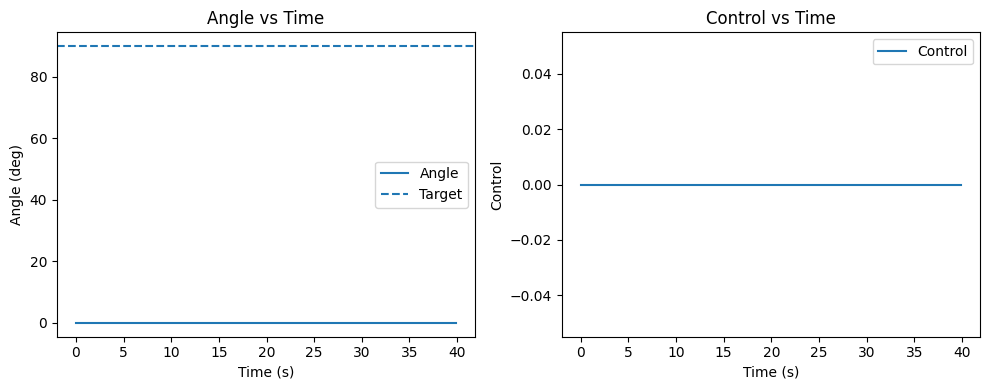

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Utility: triangular membership ----------
def trimf(x, a, b, c):
    if x <= a or x >= c:
        return 0.0
    elif x == b:
        return 1.0
    elif x < b:
        return (x - a) / (b - a)
    else:
        return (c - x) / (c - b)

# ---------- Define fuzzy sets as lambdas ----------
def err_neg(x): return trimf(x, -30, -30, 0)
def err_zero(x): return trimf(x, -10, 0, 10)
def err_pos(x): return trimf(x, 0, 30, 30)

def derr_neg(x): return trimf(x, -10, -10, 0)
def derr_zero(x): return trimf(x, -3, 0, 3)
def derr_pos(x): return trimf(x, 0, 10, 10)

# Control output universe for defuzzification
u_universe = np.linspace(-20, 20, 401)

# Membership functions for control (same shapes as before)
def u_sn(x): return trimf(x, -20, -20, -10)
def u_wn(x): return trimf(x, -15, -7, 0)
def u_z(x):  return trimf(x, -3, 0, 3)
def u_wp(x): return trimf(x, 0, 7, 15)
def u_sp(x): return trimf(x, 10, 20, 20)

# ---------- Rule evaluation (Mamdani) ----------
def evaluate_rules(e_val, de_val):
    # compute antecedent degrees
    e_neg = err_neg(e_val); e_zero = err_zero(e_val); e_pos = err_pos(e_val)
    de_neg = derr_neg(de_val); de_zero = derr_zero(de_val); de_pos = derr_pos(de_val)

    # for each rule compute firing strength and clipped consequent MF
    fired = []  # list of (strength, consequent_mf_function)
    # rules list (same logic as earlier)
    fired.append((min(e_neg, de_neg), u_sn))
    fired.append((min(e_neg, de_zero), u_wn))
    fired.append((min(e_neg, de_pos), u_z))

    fired.append((min(e_zero, de_neg), u_wn))
    fired.append((min(e_zero, de_zero), u_z))
    fired.append((min(e_zero, de_pos), u_wp))

    fired.append((min(e_pos, de_neg), u_z))
    fired.append((min(e_pos, de_zero), u_wp))
    fired.append((min(e_pos, de_pos), u_sp))

    return fired

# ---------- Defuzzify (centroid) ----------
def defuzz_centroid(combined_mf, u_univ):
    # combined_mf: list of membership values at each u_univ point
    num = np.sum(combined_mf * u_univ)
    den = np.sum(combined_mf)
    if den == 0: return 0.0
    return num / den

# ---------- Combine fired rules into aggregated MF ----------
def aggregate(fired, u_univ):
    # For each u value, aggregated membership = max over clipped consequents
    agg = np.zeros_like(u_univ)
    for strength, mf_func in fired:
        if strength <= 0: continue
        # clipped consequent MF of this rule
        vals = np.array([min(strength, mf_func(u)) for u in u_univ])
        agg = np.maximum(agg, vals)
    return agg

# ---------- Simulation ----------
target_angle = 90
cur_angle = 0.0
dt = 0.1
gain = 0.05
max_steps = 400
control_sat = 20.0

time_hist, angle_hist, control_hist = [], [], []
prev_error = target_angle - cur_angle

for step in range(max_steps):
    e = target_angle - cur_angle
    de = (e - prev_error) / dt

    fired = evaluate_rules(e, de)
    agg = aggregate(fired, u_universe)
    u_out = defuzz_centroid(agg, u_universe)

    # saturate
    u_out = max(min(u_out, control_sat), -control_sat)
    cur_angle += gain * u_out * dt

    time_hist.append(step * dt)
    angle_hist.append(cur_angle)
    control_hist.append(u_out)

    prev_error = e

    if abs(e) < 0.2 and abs(de) < 0.5:
        print(f"Converged at step {step}, angle={cur_angle:.3f}")
        break

# ---------- Plots ----------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(time_hist, angle_hist, label='Angle')
plt.axhline(target_angle, linestyle='--', label='Target')
plt.xlabel('Time (s)'); plt.ylabel('Angle (deg)'); plt.title('Angle vs Time'); plt.legend()

plt.subplot(1,2,2)
plt.plot(time_hist, control_hist, label='Control')
plt.xlabel('Time (s)'); plt.ylabel('Control'); plt.title('Control vs Time'); plt.legend()
plt.tight_layout()
plt.show()
